# 코드 실행환경

In [ ]:
Python 3.8

Numpy 버전 : 1.23.5

런타임 유형 : GPU

아키텍쳐 x86_64

# Imports

In [ ]:
#!pip install numpy==1.23.5
#!pip install -U pip setuptools wheel
#!pip install -U 'spacy[cuda-autodetect]'
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md

In [ ]:
#!pip install numpy requests nlpaug
#!pip install torch>=1.6.0 transformers>=4.11.3 sentencepiece

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import unicodedata
import re
from tqdm import tqdm
import os

import itertools
import spacy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ne_chunk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
import nlpaug.augmenter.word as naw

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 30)

[nltk_data] Downloading package punkt to /home/work/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/work/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/work/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/work/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/work/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Dataset Preparation

## Load the dataset

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 1. Data Preprocess

## Statistics before Augmentation

In [ ]:
avg_char_before_augmentation = train['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average train facts character length (before augmentation): {avg_char_before_augmentation:.0f}')

avg_word_before_augmentation = train['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average train facts word length (before augmentation): {avg_word_before_augmentation:.0f}')

Average train facts character length (before augmentation): 1109
Average train facts word length (before augmentation): 174


In [ ]:
avg_char_before_augmentation = test['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average test facts character length (before augmentation): {avg_char_before_augmentation:.0f}')

avg_word_before_augmentation = test['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average test facts word length (before augmentation): {avg_word_before_augmentation:.0f}')

Average test facts character length (before augmentation): 1111
Average test facts word length (before augmentation): 174


## Will 통일

In [ ]:
columns_to_apply = ['first_party', 'second_party', 'facts']

In [ ]:
for column in columns_to_apply:
    train[column] = train[column].apply(lambda x: re.sub(r'\bWill\b', 'Willn', x))

for column in columns_to_apply:
    test[column] = test[column].apply(lambda x: re.sub(r'\bWill\b', 'Willn', x))

## United States 통일

In [ ]:
replace_dict = {
    'U. S. C.': ' USC ',
    'U.S.C.': ' USC ',
    'U.S.A.': ' USA ',
    'U. S.': ' USA ',
    'U.S.': ' USA ',
    'US ': ' USA ',
    'United States of America': ' USA ',
    'United States': ' USA ',
    'united states': ' USA '
}

In [ ]:
for col in train.columns:
    train[col] = train[col].replace(replace_dict, regex=True)

for col in test.columns:
    test[col] = test[col].replace(replace_dict, regex=True)

In [ ]:
def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## 한글자 + '.'' 제거

In [ ]:
def remove_Large_and_Large(text):
    pattern1 = r'(?<=[A-Z])\.+\s+(?=[A-Z]+\.)'
    pattern2 = r'(?<=[A-Z])\.+(?=[A-Z]+\.)'
    pattern3 = r'([A-Z])\.'


    result1 = re.sub(pattern1, '', text)
    result2 = re.sub(pattern2, '', result1)
    result3 = re.sub(pattern3, lambda match: match.group(1)+' ', result2)

    return result3

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_Large_and_Large))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_Large_and_Large))

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## & 처리

In [ ]:
def remove_And(text):
    pattern1 = r'(?<=[A-Z])\s+\&\s+(?=[A-Z])'
    pattern2 = r'(?<=[A-Z])\&(?=[A-Z])'\

    result1 = re.sub(pattern1, 'n', text)
    result2 = re.sub(pattern2, 'n', result1)
    result3 = result2.replace('&',' and ')

    return result3

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_And))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_And))

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## 대문자 한글자 제거

In [ ]:
def remove_One_Large(text):
    text = ' ' + text + ' '
    pattern = r'(?<=\s)[A-Z](?=\s)'

    result = re.sub(pattern, ' ', text)

    return result

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_One_Large))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_One_Large))

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## Co. Bd. Mt. 처리

In [ ]:
Hon_rep = [r'Co\.', r'CO\.' , r'Bd\.', r'Mt\.']

In [ ]:
def replace_values_in_column(column, pattern, replacement):
    new_column = []
    for item in tqdm(column):
        new_item = re.sub(pattern, replacement, item)
        new_column.append(new_item)
    return new_column

# 해당 패턴에 맞는 값들을 원하는 replacement 값으로 바꾸는 함수
def replace_values_in_train(train, column_name, pattern, replacement):
    train[column_name] = replace_values_in_column(train[column_name], pattern, replacement)
    return train

def replace_values_in_test(test, column_name, pattern, replacement):
    test[column_name] = replace_values_in_column(test[column_name], pattern, replacement)
    return test

In [ ]:
# train 데이터프레임에서 각 컬럼들에 대해 값을 바꿈
for pattern, replacement in zip(Hon_rep, [' Company ', ' Company ', ' Building ', ' Mount ']):
    train = replace_values_in_train(train, 'first_party', pattern, replacement)
    train = replace_values_in_train(train, 'second_party', pattern, replacement)
    train = replace_values_in_train(train, 'facts', pattern, replacement)

100% 2478/2478 [00:00<00:00, 497700.78it/s]
100% 2478/2478 [00:00<00:00, 560537.45it/s]
100% 2478/2478 [00:00<00:00, 296566.95it/s]
100% 2478/2478 [00:00<00:00, 499590.72it/s]
100% 2478/2478 [00:00<00:00, 583936.47it/s]
100% 2478/2478 [00:00<00:00, 439786.96it/s]
100% 2478/2478 [00:00<00:00, 581161.11it/s]
100% 2478/2478 [00:00<00:00, 582888.53it/s]
100% 2478/2478 [00:00<00:00, 326377.31it/s]
100% 2478/2478 [00:00<00:00, 784473.19it/s]
100% 2478/2478 [00:00<00:00, 813643.75it/s]
100% 2478/2478 [00:00<00:00, 333039.13it/s]


In [ ]:
# test 데이터프레임에서 각 컬럼들에 대해 값을 바꿈
for pattern, replacement in zip(Hon_rep, [' Company ', ' Company ', ' Building ', ' Mount ']):
    test = replace_values_in_test(test, 'first_party', pattern, replacement)
    test = replace_values_in_test(test, 'second_party', pattern, replacement)
    test = replace_values_in_test(test, 'facts', pattern, replacement)

100% 1240/1240 [00:00<00:00, 533757.90it/s]
100% 1240/1240 [00:00<00:00, 533484.15it/s]
100% 1240/1240 [00:00<00:00, 302503.17it/s]
100% 1240/1240 [00:00<00:00, 560627.03it/s]
100% 1240/1240 [00:00<00:00, 561292.57it/s]
100% 1240/1240 [00:00<00:00, 316995.00it/s]
100% 1240/1240 [00:00<00:00, 573801.52it/s]
100% 1240/1240 [00:00<00:00, 561777.59it/s]
100% 1240/1240 [00:00<00:00, 334121.61it/s]
100% 1240/1240 [00:00<00:00, 576153.42it/s]
100% 1240/1240 [00:00<00:00, 584243.65it/s]
100% 1240/1240 [00:00<00:00, 329924.95it/s]


In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## INC 처리

In [ ]:
def remove_dot_after_inc1(text):
    pattern = r'Inc\.\s+([^A-Z\s]+)'

    def replace_dot(match):
        return match.group(0).replace(".", "")

    result = re.sub(pattern, replace_dot, text)
    return result

def remove_dot_after_inc2(text):
    pattern = r'Inc\.([^A-Z\s]+)'

    def replace_dot2(match):
        return match.group(0).replace(".", "")

    result = re.sub(pattern, replace_dot2, text)
    return result

def remove_dot_after_ltd1(text):
    pattern = r'Ltd\.\s+([^A-Z\s]+)'

    def replace_dot3(match):
        return match.group(0).replace(".", "")

    result = re.sub(pattern, replace_dot3, text)
    return result

def remove_dot_after_ltd2(text):
    pattern = r'Ltd\.([^A-Z\s]+)'

    def replace_dot4(match):
        return match.group(0).replace(".", "")

    result = re.sub(pattern, replace_dot4, text)
    return result

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_inc1))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_inc2))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_ltd1))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_ltd2))

test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_inc1))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_inc2))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_ltd1))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_dot_after_ltd2))

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

# 2. Data Augmentation

## Extracted the nouns from the facts

In [ ]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [ ]:
noun_str_train = []
noun_str_test = []

In [ ]:
noun_str_train = train['facts'].apply(lambda x: [chunk.text for chunk in nlp(x).noun_chunks]).tolist()
noun_str_test = test['facts'].apply(lambda x: [chunk.text for chunk in nlp(x).noun_chunks]).tolist()

## Augmented the data using contextual word embeddigs

In [ ]:
train_0 = train[train['first_party_winner'] == 0].copy()
train_0 = pd.concat([train_0]*5, ignore_index=True)
train_0['number'] = train_0['ID'].str.replace('TRAIN_', '').astype(int)
train_0 = train_0.sort_values('number').reset_index(drop=True)
train_0 = train_0.drop('number', axis=1)

In [ ]:
train_1 = train[train['first_party_winner'] == 1].copy()
train_1 = pd.concat([train_1]*5, ignore_index=True)
train_1['number'] = train_1['ID'].str.replace('TRAIN_', '').astype(int)
train_1 = train_1.sort_values('number').reset_index(drop=True)
train_1 = train_1.drop('number', axis=1)

In [ ]:
noun_str_train_2 = []

In [ ]:
for i in range(len(noun_str_train)):
    noun_str_train_2.append(list(set(noun_str_train[i])))

In [ ]:
final_facts_train_0 = []
final_facts_train_1 = []

In [ ]:
indices_train_0 = train[train['first_party_winner'] == 0].index.tolist()
indices_train_1 = train[train['first_party_winner'] == 1].index.tolist()

In [ ]:
for i in tqdm(indices_train_0):
    aug = naw.SynonymAug(aug_src='wordnet', stopwords=noun_str_train_2[i])
    final_facts_train_0.append([train['facts'][i]])
    for j in range(4):
        augmented_train_0 = aug.augment(train['facts'][i],1,8)
        final_facts_train_0.append(augmented_train_0)

100% 829/829 [01:02<00:00, 13.26it/s]


In [ ]:
for i in tqdm(indices_train_1):
    aug = naw.SynonymAug(aug_src='wordnet', stopwords=noun_str_train_2[i])
    final_facts_train_1.append([train['facts'][i]])
    for j in range(4):
        augmented_train_1 = aug.augment(train['facts'][i],1,8)
        final_facts_train_1.append(augmented_train_1)

100% 1649/1649 [01:59<00:00, 13.83it/s]


In [ ]:
final_facts_train_0 = [item for sublist in final_facts_train_0 for item in sublist]
final_facts_train_1 = [item for sublist in final_facts_train_1 for item in sublist]

In [ ]:
train_0['facts'] = final_facts_train_0
train_1['facts'] = final_facts_train_1

In [ ]:
train = pd.concat([train_0,train_1]).reset_index(drop=True)

In [ ]:
train['number'] = train['ID'].str.replace('TRAIN_', '').astype(int)
train = train.sort_values('ID').reset_index(drop=True)
train = train.drop('number', axis=1)
train['ID'] = train.index.map(lambda x: f'TRAIN_{x:04}')

## et al. 제거

In [ ]:
replace_dict = {

    'et. al.': ' ',
    'et. al': ' ',
    'et al.': ' ',
    'et al': ' ',

    'at. al.': ' ',
    'at. al': ' ',
    'at al.': ' ',
    'at al': ' ',

    'et. ux.': ' ',
    'et. ux': ' ',
    'et ux.': ' ',
    'et ux': ' ',

    'et. ex.': ' ',
    'et. ex': ' ',
    'et ex.': ' ',
    'et ex': ' ',

    'ex. re.': ' ',
    'ex. re': ' ',
    'ex re.': ' ',
    'ex re': ' ',

    'et. re.': ' ',
    'et. re': ' ',
    'et re.': ' ',
    'et re': ' ',

    'et. seq.': ' ',
    'et. seq': ' ',
    'et seq.': ' ',
    'et seq': ' ',

    'et. vir.': ' ',
    'et. vir': ' ',
    'et vir.': ' ',
    'et vir': ' ',

    'ex. rel.': ' ',
    'ex. rel': ' ',
    'ex rel.': ' ',
    'ex rel': ' ',
    'etc' : ' '

}

In [ ]:
for col in train.columns:
    train[col] = train[col].replace(replace_dict, regex=True)

for col in test.columns:
    test[col] = test[col].replace(replace_dict, regex=True)

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## 영어 호칭

In [ ]:
Honor = [r'Mr.', r'Mrs.', r'Miss.', r'Dr.', r'Rev.', r'Prof.', r'Capt.', r'Sgt.', r'St.', r'Sr.', r'Jr.', r'Ms.', r'No.']

In [ ]:
for i in tqdm(range(len(train))):
    for k in Honor:
        train.loc[i, 'facts'] = " " + train.loc[i, 'facts'] + " "
        train.loc[i, 'facts'] = train.loc[i, 'facts'].replace(k,' ')
        train.loc[i, 'facts'] = re.sub(r'\s+', ' ', train.loc[i, 'facts'])
        train.loc[i, 'facts'] = re.sub(r"^\s+|\s+$", "", train.loc[i, 'facts'])

        train.loc[i, 'first_party'] = " " + train.loc[i, 'first_party'] + " "
        train.loc[i, 'first_party'] = train.loc[i, 'first_party'].replace(k,' ')
        train.loc[i, 'first_party'] = re.sub(r'\s+', ' ', train.loc[i, 'first_party'])
        train.loc[i, 'first_party'] = re.sub(r"^\s+|\s+$", "", train.loc[i, 'first_party'])

        train.loc[i, 'second_party'] = " " + train.loc[i, 'second_party'] + " "
        train.loc[i, 'second_party'] = train.loc[i, 'second_party'].replace(k,' ')
        train.loc[i, 'second_party'] = re.sub(r'\s+', ' ', train.loc[i, 'second_party'])
        train.loc[i, 'second_party'] = re.sub(r"^\s+|\s+$", "", train.loc[i, 'second_party'])


for i in tqdm(range(len(test))):
    for k in Honor:
        test.loc[i, 'facts'] = " " + test.loc[i, 'facts'] + " "
        test.loc[i, 'facts'] = test.loc[i, 'facts'].replace(k,' ')
        test.loc[i, 'facts'] = re.sub(r'\s+', ' ', test.loc[i, 'facts'])
        test.loc[i, 'facts'] = re.sub(r"^\s+|\s+$", "", test.loc[i, 'facts'])

        test.loc[i, 'first_party'] = " " + test.loc[i, 'first_party'] + " "
        test.loc[i, 'first_party'] = test.loc[i, 'first_party'].replace(k,' ')
        test.loc[i, 'first_party'] = re.sub(r'\s+', ' ', test.loc[i, 'first_party'])
        test.loc[i, 'first_party'] = re.sub(r"^\s+|\s+$", "", test.loc[i, 'first_party'])

        test.loc[i, 'second_party'] = " " + test.loc[i, 'second_party'] + " "
        test.loc[i, 'second_party'] = test.loc[i, 'second_party'].replace(k,' ')
        test.loc[i, 'second_party'] = re.sub(r'\s+', ' ', test.loc[i, 'second_party'])
        test.loc[i, 'second_party'] = re.sub(r"^\s+|\s+$", "", test.loc[i, 'second_party'])

100% 12390/12390 [02:48<00:00, 73.49it/s]
100% 1240/1240 [00:16<00:00, 73.52it/s]


In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))

## Sentence Segmentation

In [ ]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_md")

In [ ]:
sentence_train = []
sentence_test = []

In [ ]:
train['facts'] = train['facts'].apply(lambda text: ' '.join([str(sent) + ' [SEP]' for sent in nlp(text).sents]))
test['facts'] = test['facts'].apply(lambda text: ' '.join([str(sent) + ' [SEP]' for sent in nlp(text).sents]))

# 3. Preprocess Dataset

## Statistics before Preprocessing

In [ ]:
avg_char_before_preprocessing = train['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average train facts character length (before preprocessing): {avg_char_before_preprocessing:.0f}')

avg_word_before_preprocessing = train['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average train facts word length (before preprocessing): {avg_word_before_preprocessing:.0f}')

Average train facts character length (before preprocessing): 1165
Average train facts word length (before preprocessing): 190


In [ ]:
avg_char_before_preprocessing = test['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average test facts character length (before preprocessing): {avg_char_before_preprocessing:.0f}')

avg_word_before_preprocessing = test['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average test facts word length (before preprocessing): {avg_word_before_preprocessing:.0f}')

Average test facts character length (before preprocessing): 1149
Average test facts word length (before preprocessing): 181


## Text Preprocessing Functions

In [ ]:
def remove_html_tags_func(text):
    return BeautifulSoup(text, 'html.parser').get_text()


def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)


def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)


def remove_irr_char_func(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)


def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def remove_english_stopwords_func(text):
    t = [token for token in text if token.lower() not in stopwords.words("english")]
    text = ' '.join(t)
    return text

def norm_lemm_v_a_func(text):
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

def remove_single_char_func(text, threshold=1):
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

## Text Cleaning

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.str.lower())
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_html_tags_func))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_url_func))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_accented_chars_func))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_punctuation_func))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_irr_char_func))
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
train['facts'] = train['facts'].apply(lambda x: x.replace('cls', 'CLS').replace('sep', 'SEP'))

In [ ]:
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.str.lower())
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_html_tags_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_url_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_accented_chars_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_punctuation_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_irr_char_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_extra_whitespaces_func))
test['facts'] = test['facts'].apply(lambda x: x.replace('cls', 'CLS').replace('sep', 'SEP'))

## Tokenization

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(word_tokenize))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(word_tokenize))

## Stop Words

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_english_stopwords_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_english_stopwords_func))

## Normalization

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(norm_lemm_v_a_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(norm_lemm_v_a_func))

## Removing Single Characters

In [ ]:
train[columns_to_apply] = train[columns_to_apply].apply(lambda x: x.apply(remove_single_char_func))
test[columns_to_apply] = test[columns_to_apply].apply(lambda x: x.apply(remove_single_char_func))

## Statistics after Preprocessing

In [ ]:
avg_char_after_preprocessing = train['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average train facts character length (after preprocessing): {avg_char_after_preprocessing:.0f}')

avg_word_after_preprocessing = train['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average train facts word length (after preprocessing): {avg_word_after_preprocessing:.0f}')

Average train facts character length (after preprocessing): 798
Average train facts word length (after preprocessing): 111


In [ ]:
avg_char_after_preprocessing = test['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average test facts character length (after preprocessing): {avg_char_after_preprocessing:.0f}')

avg_word_after_preprocessing = test['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average test facts word length (after preprocessing): {avg_word_after_preprocessing:.0f}')

Average test facts character length (after preprocessing): 786
Average test facts word length (after preprocessing): 109


# 4. Text Exploration

## Text Exploration Functions

In [ ]:
def most_common_word_func(text, n_words=25):
    words = word_tokenize(text)
    fdist = FreqDist(words)

    n_words = n_words

    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)

    return df_fdist

def label_func(winner):
    if winner == 0:
        return 'second_party'
    elif winner == 1:
        return 'first_party'

def least_common_word_func(text, n_words=25):
    words = word_tokenize(text)
    fdist = FreqDist(words)

    n_words = n_words

    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).tail(n_words)

    return df_fdist

In [ ]:
df_copy = pd.concat([train.iloc[:,:-1],test]).reset_index(drop=True)
train_copy = train.copy()
test_copy = test.copy()

## Most common Words

In [ ]:
text_corpus = df_copy['facts'].str.cat(sep=' ')

df_most_common_words_text_corpus = most_common_word_func(text_corpus)

df_most_common_words_text_corpus[~df_most_common_words_text_corpus['Word'].isin(['SEP', 'CLS'])].head(10)

,Word,Frequency
41,court,46795
42,appeal,17784
160,district,16464
191,state,13263
162,usa,11165
196,federal,9837
40,circuit,9229
44,hold,9157
46,act,9138
409,claim,9029


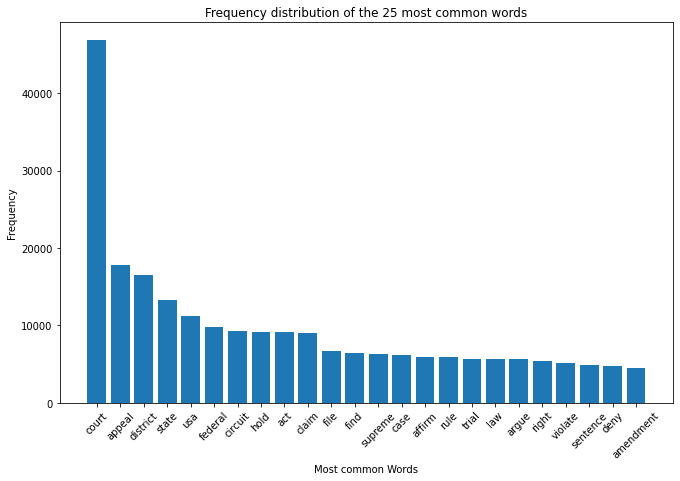

In [ ]:
plt.figure(figsize=(11,7))
plt.bar(df_most_common_words_text_corpus[~df_most_common_words_text_corpus['Word'].isin(['SEP', 'CLS'])]['Word'],
        df_most_common_words_text_corpus[~df_most_common_words_text_corpus['Word'].isin(['SEP', 'CLS'])]['Frequency'])

plt.xticks(rotation = 45)

plt.xlabel('Most common Words')
plt.ylabel("Frequency")
plt.title("Frequency distribution of the 25 most common words")

plt.show()

## For parts of the DF

In [ ]:
train_copy['Label'] = train_copy['first_party_winner'].apply(label_func)

In [ ]:
cols = list(train_copy.columns)
cols = [cols[-1]] + cols[:-1]
train_copy = train_copy[cols]

In [ ]:
first_party = train_copy[(train_copy["Label"] == 'first_party')]['facts']
second_party = train_copy[(train_copy["Label"] == 'second_party')]['facts']

In [ ]:
text_corpus_first_party = first_party.str.cat(sep=' ')
text_corpus_second_party = second_party.str.cat(sep=' ')

In [ ]:
df_most_common_words_text_corpus_first_party = most_common_word_func(text_corpus_first_party)
df_most_common_words_text_corpus_second_party = most_common_word_func(text_corpus_second_party)

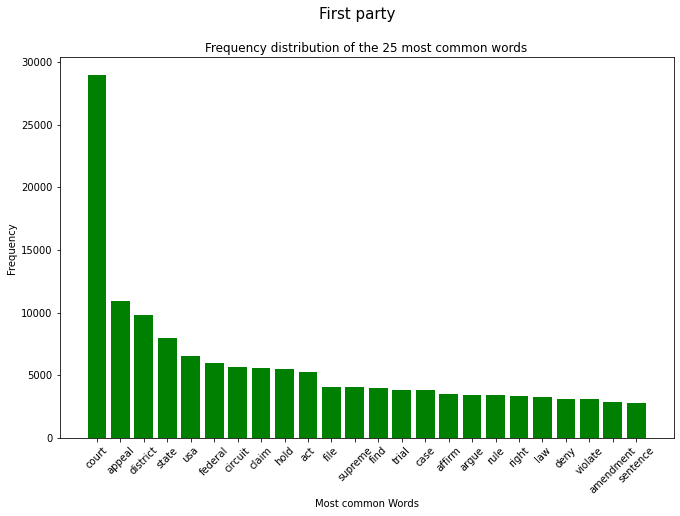

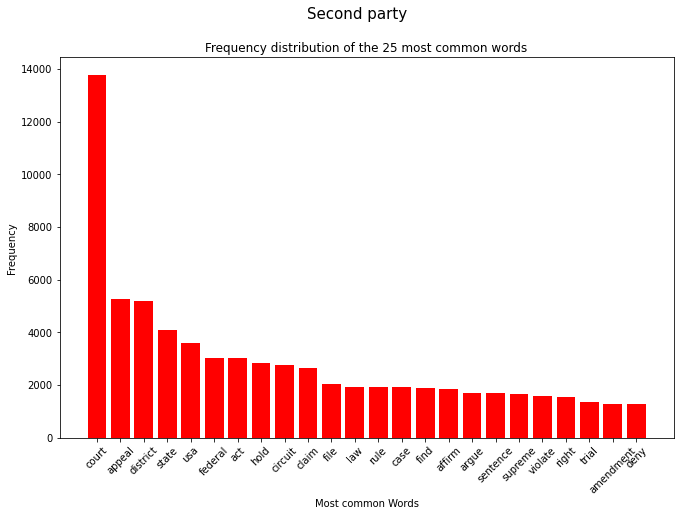

In [ ]:
splited_data = [df_most_common_words_text_corpus_first_party[~df_most_common_words_text_corpus_first_party['Word'].isin(['SEP', 'CLS'])],
                df_most_common_words_text_corpus_second_party[~df_most_common_words_text_corpus_second_party['Word'].isin(['SEP', 'CLS'])]]

color_list = ['green', 'red']
title_list = ['First party', 'Second party']


for item in range(2):
    plt.figure(figsize=(11,7))
    plt.bar(splited_data[item]['Word'],
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xticks(rotation = 45)
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

# 5. Tokenize

## Data resampling

In [ ]:
train_02 = train.copy()

In [ ]:
train_02['first_party'], train_02['second_party'] = train_02['second_party'], train_02['first_party']
train_02['first_party_winner'] = 1 - train_02['first_party_winner']

In [ ]:
train_02 = pd.concat([train, train_02], ignore_index=True)

In [ ]:
train_02['number'] = train_02['ID'].str.replace('TRAIN_', '').astype(int)

In [ ]:
train_02 = train_02.sort_values(['number', 'first_party_winner']).reset_index(drop=True)

In [ ]:
train = train_02.drop('number', axis=1)

In [ ]:
train['ID'] = 'TRAIN_' + train.index.map(lambda x: f'{x:04}')

## Special token

In [ ]:
for column in columns_to_apply:
    train[column] = train[column].apply(lambda x: re.sub(r'\bSEP\b', '[SEP]', x))

for column in columns_to_apply:
    test[column] = test[column].apply(lambda x: re.sub(r'\bSEP\b', '[SEP]', x))

In [ ]:
train['facts'] = '[CLS] ' + train['first_party'] + ' [SEP] ' + train['second_party'] + ' [SEP] ' + train['facts']
test['facts'] = '[CLS] ' + test['first_party'] + ' [SEP] ' + test['second_party'] + ' [SEP] ' + test['facts']

## To_csv

In [ ]:
train.to_csv('train_last_3.csv', index = False)
test.to_csv('test_last_3.csv', index = False)

# Modeling(Model-6,7,8 - Kfold[0~3])

## Use tokenizer

In [ ]:
train = pd.read_csv('./train_last_3.csv')
test = pd.read_csv('./test_last_3.csv')

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from torch.nn import BCEWithLogitsLoss

In [ ]:
model_type = "sileod/deberta-v3-base-tasksource-nli"
tokenizer = AutoTokenizer.from_pretrained(model_type)
config = AutoConfig.from_pretrained(model_type)
model_01 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_02 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_03 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)

In [ ]:
def tokenize_texts(texts, tokenizer, max_len=352):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, add_special_tokens=False , return_tensors='pt')

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenize_texts(text, self.tokenizer, self.max_len)
        return {'input_ids': encoding['input_ids'][0], 'attention_mask': encoding['attention_mask'][0], 'label': torch.tensor(label)}

## Data_loader

In [ ]:
k_folds = [1, 2, 3]
train_indices = []
val_indices = []

In [ ]:
train_index = train.iloc[list(range(0, 24780, 10))]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_val_splits = list(skf.split(train_index, train_index['first_party_winner']))

In [ ]:
for k_fold in k_folds:
    train_train =  list(train_index.iloc[train_val_splits[k_fold][0],:].index)
    train_val =  list(train_index.iloc[train_val_splits[k_fold][1],:].index)

    train_list = train_train[:]
    val_list = train_val[:]

    for num in train_train:
        for i in range(1, 10):
            new_value = num + i
            train_list.append(new_value)

    for num in train_val:
        for i in range(1, 10):
            new_value = num + i
            val_list.append(new_value)

    train_list = sorted(train_list)
    val_list = sorted(val_list)

    train_indices.append(sorted(train_list))
    val_indices.append(sorted(val_list))

In [ ]:
train_data_01 = train.iloc[train_indices[0]]
val_data_01 = train.iloc[val_indices[0]]

train_data_02 = train.iloc[train_indices[1]]
val_data_02 = train.iloc[val_indices[1]]

train_data_03 = train.iloc[train_indices[2]]
val_data_03 = train.iloc[val_indices[2]]

In [ ]:
train_dataset_01 = NewsDataset(train_data_01['facts'].to_numpy(), train_data_01['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_01 = NewsDataset(val_data_01['facts'].to_numpy(), val_data_01['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_02 = NewsDataset(train_data_02['facts'].to_numpy(), train_data_02['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_02 = NewsDataset(val_data_02['facts'].to_numpy(), val_data_02['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_03 = NewsDataset(train_data_03['facts'].to_numpy(), train_data_03['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_03 = NewsDataset(val_data_03['facts'].to_numpy(), val_data_03['first_party_winner'].to_numpy(), tokenizer, max_len=352)

In [ ]:
train_loader_01 = DataLoader(train_dataset_01, batch_size=32, shuffle=True)
val_loader_01 = DataLoader(val_dataset_01, batch_size=32, shuffle=False)

train_loader_02 = DataLoader(train_dataset_02, batch_size=32, shuffle=True)
val_loader_02 = DataLoader(val_dataset_02, batch_size=32, shuffle=False)

train_loader_03 = DataLoader(train_dataset_03, batch_size=32, shuffle=True)
val_loader_03 = DataLoader(val_dataset_03, batch_size=32, shuffle=False)

# Modeling

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_01.to(device)
model_02.to(device)
model_03.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
optimizer_01 = AdamW(model_01.parameters(), lr=1e-5)
optimizer_02 = AdamW(model_02.parameters(), lr=1e-5)
optimizer_03 = AdamW(model_03.parameters(), lr=1e-5)

In [ ]:
# Loss function
num_classes = 2
smoothing = 0.01
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=smoothing).to(device)

In [ ]:
# Step 7: Training and validation
def train(model, data_loader, optimizer, device):
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        loss = criterion(logits, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(losses)




def eval(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    return y_true, y_pred

## Model_06 - Kfold[1]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03]
val_loader = [val_loader_01, val_loader_02, val_loader_03]
model_loader = [model_01, model_02, model_03]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03]


best_accuracy_01 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[0], train_loader[0], optimizer_loader[0], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[0], train_loader[0], device)
    y_true_val, y_pred_val = eval(model_loader[0], val_loader[0], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_01:
        best_accuracy_01 = val_accuracy
        torch.save(model_loader[0].state_dict(), f'model_loader[0]_{k_folds[0]}.pt')

    torch.cuda.empty_cache()

Epoch: 1
Train Loss: 0.7588645669721787
Train Accuracy: 0.5000504540867811
Val Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2480
           1       0.50      0.00      0.00      2480

    accuracy                           0.50      4960
   macro avg       0.50      0.50      0.34      4960
weighted avg       0.50      0.50      0.34      4960

Epoch: 2
Train Loss: 0.7525046064007667
Train Accuracy: 0.5
Val Accuracy: 0.5004032258064516
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2480
           1       1.00      0.00      0.00      2480

    accuracy                           0.50      4960
   macro avg       0.75      0.50      0.33      4960
weighted avg       0.75      0.50      0.33      4960

Epoch: 3
Train Loss: 0.7156338517704318
Train Accuracy: 0.8645812310797174
Val Accuracy: 0.5082661290322581
              precision    recall  f1-score   suppor

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_01.load_state_dict(torch.load(f'model_loader[0]_1.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_01, test_loader, device)
submit['first_party_winner_01'] = test_predictions

In [ ]:
submit_01 = submit.copy()

In [ ]:
submit_01.to_csv('submit_01_version2.csv', index = False)

## Model_07 - Kfold[2]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03]
val_loader = [val_loader_01, val_loader_02, val_loader_03]
model_loader = [model_01, model_02, model_03]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03]


best_accuracy_02 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[1], train_loader[1], optimizer_loader[1], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[1], train_loader[1], device)
    y_true_val, y_pred_val = eval(model_loader[1], val_loader[1], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_02:
        best_accuracy_02 = val_accuracy
        torch.save(model_loader[1].state_dict(), f'model_loader[1]_{k_folds[1]}.pt')

    torch.cuda.empty_cache()

Epoch: 1
Train Loss: 0.7570201812251922
Train Accuracy: 0.499949545913219
Val Accuracy: 0.4997983870967742
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      2480
           1       0.50      1.00      0.67      2480

    accuracy                           0.50      4960
   macro avg       0.42      0.50      0.33      4960
weighted avg       0.42      0.50      0.33      4960

Epoch: 2
Train Loss: 0.7523185186809109
Train Accuracy: 0.500100908173562
Val Accuracy: 0.4993951612903226
              precision    recall  f1-score   support

           0       0.36      0.00      0.00      2480
           1       0.50      1.00      0.67      2480

    accuracy                           0.50      4960
   macro avg       0.43      0.50      0.33      4960
weighted avg       0.43      0.50      0.33      4960

Epoch: 3
Train Loss: 0.7376240247680295
Train Accuracy: 0.75343087790111
Val Accuracy: 0.5058467741935484
              precision   

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_02.load_state_dict(torch.load(f'model_loader[1]_2.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_02, test_loader, device)
submit['first_party_winner_02'] = test_predictions

In [ ]:
submit_02 = submit.copy()

In [ ]:
submit_02.to_csv('submit_02_version2.csv', index = False)

## Model_08 - Kfold[3]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03]
val_loader = [val_loader_01, val_loader_02, val_loader_03]
model_loader = [model_01, model_02, model_03]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03]


best_accuracy_03 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[2], train_loader[2], optimizer_loader[2], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[2], train_loader[2], device)
    y_true_val, y_pred_val = eval(model_loader[2], val_loader[2], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_03:
        best_accuracy_03 = val_accuracy
        torch.save(model_loader[2].state_dict(), f'model_loader[2]_{k_folds[2]}.pt')

    torch.cuda.empty_cache()

Epoch: 1
Train Loss: 0.7587257154526249
Train Accuracy: 0.5
Val Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2475
           1       0.50      1.00      0.67      2475

    accuracy                           0.50      4950
   macro avg       0.25      0.50      0.33      4950
weighted avg       0.25      0.50      0.33      4950

Epoch: 2
Train Loss: 0.751991155935872
Train Accuracy: 0.5090771558245083
Val Accuracy: 0.5022222222222222
              precision    recall  f1-score   support

           0       0.50      0.88      0.64      2475
           1       0.51      0.13      0.20      2475

    accuracy                           0.50      4950
   macro avg       0.51      0.50      0.42      4950
weighted avg       0.51      0.50      0.42      4950

Epoch: 3
Train Loss: 0.7477926481154658
Train Accuracy: 0.6386283408976299
Val Accuracy: 0.5167676767676768
              precision    recall  f1-score   support

In [ ]:
best_accuracy_03

0.547070707070707

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_03.load_state_dict(torch.load(f'model_loader[2]_3.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_03, test_loader, device)
submit['first_party_winner_03'] = test_predictions

In [ ]:
submit_03 = submit.copy()

In [ ]:
submit_03.to_csv('submit_03_version2.csv', index = False)

# Modeling(Model-6,7,8 - Kfold[0~3])

In [ ]:
train = pd.read_csv('/data/train_last_3.csv')
test = pd.read_csv('/data/test_last_3.csv')

In [ ]:
model_type = "sileod/deberta-v3-base-tasksource-nli"
tokenizer = AutoTokenizer.from_pretrained(model_type)
config = AutoConfig.from_pretrained(model_type)
model_01 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_02 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_03 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_04 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)
model_05 = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)

In [ ]:
def tokenize_texts(texts, tokenizer, max_len=352):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, add_special_tokens=False , return_tensors='pt')

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenize_texts(text, self.tokenizer, self.max_len)
        return {'input_ids': encoding['input_ids'][0], 'attention_mask': encoding['attention_mask'][0], 'label': torch.tensor(label)}

## Data_loader

In [ ]:
k_folds = [0, 1, 2, 3, 4]
train_indices = []
val_indices = []

In [ ]:
train_index = train.iloc[list(range(0, 24780, 10))]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_val_splits = list(skf.split(train_index, train_index['first_party_winner']))

In [ ]:
for k_fold in k_folds:
    train_train =  list(train_index.iloc[train_val_splits[k_fold][0],:].index)
    train_val =  list(train_index.iloc[train_val_splits[k_fold][1],:].index)

    train_list = train_train[:]
    val_list = train_val[:]

    for num in train_train:
        for i in range(1, 10):
            new_value = num + i
            train_list.append(new_value)

    for num in train_val:
        for i in range(1, 10):
            new_value = num + i
            val_list.append(new_value)

    train_list = sorted(train_list)
    val_list = sorted(val_list)

    train_indices.append(sorted(train_list))
    val_indices.append(sorted(val_list))

In [ ]:
train_data_01 = train.iloc[train_indices[0]]
val_data_01 = train.iloc[val_indices[0]]

train_data_02 = train.iloc[train_indices[1]]
val_data_02 = train.iloc[val_indices[1]]

train_data_03 = train.iloc[train_indices[2]]
val_data_03 = train.iloc[val_indices[2]]

train_data_04 = train.iloc[train_indices[3]]
val_data_04 = train.iloc[val_indices[3]]

train_data_05 = train.iloc[train_indices[4]]
val_data_05 = train.iloc[val_indices[4]]

In [ ]:
train_dataset_01 = NewsDataset(train_data_01['facts'].to_numpy(), train_data_01['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_01 = NewsDataset(val_data_01['facts'].to_numpy(), val_data_01['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_02 = NewsDataset(train_data_02['facts'].to_numpy(), train_data_02['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_02 = NewsDataset(val_data_02['facts'].to_numpy(), val_data_02['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_03 = NewsDataset(train_data_03['facts'].to_numpy(), train_data_03['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_03 = NewsDataset(val_data_03['facts'].to_numpy(), val_data_03['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_04 = NewsDataset(train_data_04['facts'].to_numpy(), train_data_04['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_04 = NewsDataset(val_data_04['facts'].to_numpy(), val_data_04['first_party_winner'].to_numpy(), tokenizer, max_len=352)

train_dataset_05 = NewsDataset(train_data_05['facts'].to_numpy(), train_data_05['first_party_winner'].to_numpy(), tokenizer, max_len=352)
val_dataset_05 = NewsDataset(val_data_05['facts'].to_numpy(), val_data_05['first_party_winner'].to_numpy(), tokenizer, max_len=352)

In [ ]:
train_loader_01 = DataLoader(train_dataset_01, batch_size=32, shuffle=True)
val_loader_01 = DataLoader(val_dataset_01, batch_size=32, shuffle=False)

train_loader_02 = DataLoader(train_dataset_02, batch_size=32, shuffle=True)
val_loader_02 = DataLoader(val_dataset_02, batch_size=32, shuffle=False)

train_loader_03 = DataLoader(train_dataset_03, batch_size=32, shuffle=True)
val_loader_03 = DataLoader(val_dataset_03, batch_size=32, shuffle=False)

train_loader_04 = DataLoader(train_dataset_04, batch_size=32, shuffle=True)
val_loader_04 = DataLoader(val_dataset_04, batch_size=32, shuffle=False)

train_loader_05 = DataLoader(train_dataset_05, batch_size=32, shuffle=True)
val_loader_05 = DataLoader(val_dataset_05, batch_size=32, shuffle=False)

# Modeling

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_01.to(device)
model_02.to(device)
model_03.to(device)
model_04.to(device)
model_05.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
optimizer_01 = AdamW(model_01.parameters(), lr=1e-5)
optimizer_02 = AdamW(model_02.parameters(), lr=1e-5)
optimizer_03 = AdamW(model_03.parameters(), lr=1e-5)
optimizer_04 = AdamW(model_04.parameters(), lr=1e-5)
optimizer_05 = AdamW(model_05.parameters(), lr=1e-5)

In [ ]:
# Loss function
num_classes = 2
smoothing = 0.01
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=smoothing).to(device)

In [ ]:
# Step 7: Training and validation
def train(model, data_loader, optimizer, device):
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        loss = criterion(logits, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(losses)




def eval(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    return y_true, y_pred

## Model_01 - Kfold[1]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
val_loader = [val_loader_01, val_loader_02, val_loader_03, val_loader_04, val_loader_05]
model_loader = [model_01, model_02, model_03, model_04, model_05]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03, optimizer_04, optimizer_05]


best_accuracy_01 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[0], train_loader[0], optimizer_loader[0], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[0], train_loader[0], device)
    y_true_val, y_pred_val = eval(model_loader[0], val_loader[0], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_01:
        best_accuracy_01 = val_accuracy
        torch.save(model_loader[0].state_dict(), f'model_fine_loader[0]_{k_folds[0]}.pt')

    torch.cuda.empty_cache()

In [ ]:
best_accuracy_01

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_01.load_state_dict(torch.load(f'model_fine_loader[0]_1.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_01, test_loader, device)
submit['first_party_winner_01'] = test_predictions

In [ ]:
submit_01 = submit.copy()

In [ ]:
submit_01.to_csv('submit_01_version3.csv', index = False)

## Model_02 - Kfold[2]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
val_loader = [val_loader_01, val_loader_02, val_loader_03, val_loader_04, val_loader_05]
model_loader = [model_01, model_02, model_03, model_04, model_05]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03, optimizer_04, optimizer_05]


best_accuracy_02 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[1], train_loader[1], optimizer_loader[1], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[1], train_loader[1], device)
    y_true_val, y_pred_val = eval(model_loader[1], val_loader[1], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_02:
        best_accuracy_02 = val_accuracy
        torch.save(model_loader[1].state_dict(), f'model_fine_loader[1]_{k_folds[1]}.pt')

    torch.cuda.empty_cache()

In [ ]:
best_accuracy_02

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_02.load_state_dict(torch.load(f'model_fine_loader[1]_2.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_02, test_loader, device)
submit['first_party_winner_02'] = test_predictions

In [ ]:
submit_02 = submit.copy()

In [ ]:
submit_02.to_csv('submit_02_version3.csv', index = False)

## Model_03 - Kfold[3]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
val_loader = [val_loader_01, val_loader_02, val_loader_03, val_loader_04, val_loader_05]
model_loader = [model_01, model_02, model_03, model_04, model_05]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03, optimizer_04, optimizer_05]


best_accuracy_03 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[2], train_loader[2], optimizer_loader[2], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[2], train_loader[2], device)
    y_true_val, y_pred_val = eval(model_loader[2], val_loader[2], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_03:
        best_accuracy_03 = val_accuracy
        torch.save(model_loader[2].state_dict(), f'model_fine_loader[2]_{k_folds[2]}.pt')

    torch.cuda.empty_cache()

In [ ]:
best_accuracy_03

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_03.load_state_dict(torch.load(f'model_fine_loader[2]_3.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_03, test_loader, device)
submit['first_party_winner_03'] = test_predictions

In [ ]:
submit_03 = submit.copy()

In [ ]:
submit_03.to_csv('submit_03_version3.csv', index = False)

## Model_04 - Kfold[4]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
val_loader = [val_loader_01, val_loader_02, val_loader_03, val_loader_04, val_loader_05]
model_loader = [model_01, model_02, model_03, model_04, model_05]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03, optimizer_04, optimizer_05]


best_accuracy_04 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[3], train_loader[3], optimizer_loader[3], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[3], train_loader[3], device)
    y_true_val, y_pred_val = eval(model_loader[3], val_loader[3], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_04:
        best_accuracy_04 = val_accuracy
        torch.save(model_loader[3].state_dict(), f'model_fine_loader[3]_{k_folds[3]}.pt')

    torch.cuda.empty_cache()

In [ ]:
best_accuracy_04

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_04.load_state_dict(torch.load(f'model_fine_loader[3]_4.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_04, test_loader, device)
submit['first_party_winner_04'] = test_predictions

In [ ]:
submit_04 = submit.copy()

In [ ]:
submit_04.to_csv('submit_04_version3.csv', index = False)

## Model_05 - Kfold[5]

In [ ]:
train_loader = [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
val_loader = [val_loader_01, val_loader_02, val_loader_03, val_loader_04, val_loader_05]
model_loader = [model_01, model_02, model_03, model_04, model_05]
optimizer_loader = [optimizer_01, optimizer_02, optimizer_03, optimizer_04, optimizer_05]


best_accuracy_05 = 0

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    train_loss = train(model_loader[4], train_loader[4], optimizer_loader[4], device)
    print(f"Train Loss: {train_loss}")
    y_true_train, y_pred_train = eval(model_loader[4], train_loader[4], device)
    y_true_val, y_pred_val = eval(model_loader[4], val_loader[4], device)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Val Accuracy: {val_accuracy}")
    print(classification_report(y_true_val, y_pred_val))

    if val_accuracy > best_accuracy_05:
        best_accuracy_05 = val_accuracy
        torch.save(model_loader[4].state_dict(), f'model_fine_loader[4]_{k_folds[4]}.pt')

    torch.cuda.empty_cache()

Epoch: 1
Train Loss: 0.7618346896863752
Train Accuracy: 0.5004538577912254
Val Accuracy: 0.5002020202020202
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      2475
           1       0.50      0.10      0.16      2475

    accuracy                           0.50      4950
   macro avg       0.50      0.50      0.40      4950
weighted avg       0.50      0.50      0.40      4950

Epoch: 2
Train Loss: 0.7545804811100806
Train Accuracy: 0.500100857286939
Val Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2475
           1       0.50      0.00      0.00      2475

    accuracy                           0.50      4950
   macro avg       0.50      0.50      0.34      4950
weighted avg       0.50      0.50      0.34      4950

Epoch: 3
Train Loss: 0.7528529493078109
Train Accuracy: 0.5011094301563288
Val Accuracy: 0.5
              precision    recall  f1-score   support

In [ ]:
best_accuracy_05

0.5567676767676768

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
model_05.load_state_dict(torch.load(f'model_fine_loader[4]_4.pt'))
test_dataset = NewsDataset(test['facts'].to_numpy(), np.zeros(len(test)), tokenizer, max_len=352)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
_, test_predictions = eval(model_05, test_loader, device)
submit['first_party_winner_05'] = test_predictions

In [ ]:
submit_05 = submit.copy()

In [ ]:
submit_05.to_csv('./data/submit_05_version4.csv', index = False)

## Ensemble

In [ ]:
from scipy.stats import mode

In [ ]:
submit_01 = pd.read_csv('./data/submit_01_version4.csv')
submit_02 = pd.read_csv('./data/submit_02_version4.csv')
submit_03 = pd.read_csv('./data/submit_03_version4.csv')
submit_04 = pd.read_csv('./data/submit_04_version4.csv')
submit_05 = pd.read_csv('./data/submit_05_version4.csv')
submit_06 = pd.read_csv('/data/submit_01_version2.csv')
submit_07 = pd.read_csv('/data/submit_02_version2.csv')
submit_08 = pd.read_csv('/data/submit_03_version2.csv')

In [ ]:
submit_06.columns = ['ID','first_party_winner','first_party_winner_06']
submit_07.columns = ['ID','first_party_winner','first_party_winner_07']
submit_08.columns = ['ID','first_party_winner','first_party_winner_08']

In [ ]:
submission = pd.merge(submit_01, submit_02, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_03, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_04, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_05, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_06, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_07, on=['ID', 'first_party_winner'])
submission = pd.merge(submission, submit_08, on=['ID', 'first_party_winner'])

In [ ]:
submission['first_party_winner'] = submission[['first_party_winner_01','first_party_winner_02', 'first_party_winner_03','first_party_winner_04','first_party_winner_05','first_party_winner_06','first_party_winner_07','first_party_winner_08']].mode(axis=1)[0]

In [ ]:
submission['first_party_winner'] = submission['first_party_winner'].astype(int)

In [ ]:
submission

,ID,first_party_winner,first_party_winner_01,first_party_winner_02,first_party_winner_03,first_party_winner_04,first_party_winner_05,first_party_winner_06,first_party_winner_07,first_party_winner_08
0,TEST_0000,0.0,0,0,0,0,0,0,0,0
1,TEST_0001,0.0,0,1,0,0,1,0,0,1
2,TEST_0002,1.0,1,1,1,0,0,1,0,1
3,TEST_0003,0.0,1,0,1,0,0,1,0,0
4,TEST_0004,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1235,TEST_1235,0.0,1,0,1,0,0,1,1,0
1236,TEST_1236,0.0,0,0,1,0,0,0,0,0
1237,TEST_1237,0.0,1,0,0,0,0,0,0,0
1238,TEST_1238,1.0,1,1,0,0,1,1,0,1


In [ ]:
submission = submission.iloc[:,:2]

In [ ]:
submission.to_csv('submission_minsu_version_04.csv', index = False)